<a href="https://colab.research.google.com/github/RefiloeShabe/Solving-Black-Scholes-PDE-using-ANN/blob/master/Black_Scholes_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Refiloe Sarah Shabe (refiloe@aims.ac.za)


In [0]:
import autograd.numpy as np
np.random.seed(1337)
from autograd import grad, jacobian
#from autograd.optimize import GD
import autograd.numpy.random as npr

from matplotlib import pyplot as plt
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D 


from scipy.integrate import quad
%matplotlib inline



In [0]:
from google.colab import files

# Dataset

In [0]:
# Bounds of s and t
smax = 45
T = 1

# Declaring and initialising constant variables
sigma = 0.55       # implied volatility
r = 0.01         # interest rate
k = 15         # Strike price

# Number of stock prices and times recorded
Ns = 60
Nt = 60

# Training data: Stock prices s_space at given times t_space
s_space = np.linspace(0, smax,Ns)
tau_space = np.linspace(0, T,Nt)

#Testing Data
s_test = np.linspace(2, 30, 20)
tau_test = np.linspace(0.2, 0.6, 20)



## THE ANALYTICAL SOLUTION

In [0]:
def integrand(y):
    return np.exp(-0.5 * y**2)

def N(x):
  return quad(integrand, -np.inf, x)[0] * (1 / np.sqrt(2 * np.pi)) 

def d_1(input_pnt):
  return (np.log(input_pnt[0] / k) + (r + 0.5* sigma**2)*(input_pnt[1]) ) / (sigma * np.sqrt(input_pnt[1]))

def d_2(input_pnt):
  return  (np.log(input_pnt[0] / k) - (r + 0.5* sigma**2)*(input_pnt[1]) ) / (sigma * np.sqrt(input_pnt[1]))

def analytical(s,t):
  V_analytic = np.zeros((len(t),len(s)))
  for i, ti in enumerate (t):
    for j, si in enumerate (s):
      input_point = np.array([si,ti]) 
      if input_point[0] == 0:
        V_analytic[i][j] = 0
      elif input_point[0] == smax:
        V_analytic[i][j] = smax - (k * np.exp(-r*(input_point[1])))
      elif input_point[1] == 0:
        V_analytic[i][j] = max(input_point[0] - k, 0)    
      else:    
        V_analytic[i][j] = (input_point[0] * N(d_1(input_point))) - (k * np.exp(-r * (input_point[1])) * N(d_2(input_point)))
  return V_analytic    

In [0]:
V_exact = analytical(s_space,tau_space)

## XAVIER GLOROT INITIALIZATION

In [0]:
n_feature = 2
n_class = 1
def network1(n_hidden=10):
    model = dict(
        W0= np.random.uniform(-np.sqrt(1/2),np.sqrt(1/2),(n_feature, n_hidden)),
        W1=np.random.uniform(-np.sqrt(6/11),np.sqrt(6/11), (n_hidden, n_class)),
        W2= np.zeros(n_hidden),
        W3= np.zeros(n_class)
    )

    return model

In [0]:
model = network1()

In [0]:
#def tanh(input_pnt):                    
#    return (np.exp(input_pnt) - np.exp(input_pnt)) / (np.exp(input_pnt) + np.exp(input_pnt))

def sigmoid(input_pnt):                    # The activation function  
  return 1. / (1 + np.exp(-input_pnt))

def forward(input_pnt,model):
  """This function defines a neural network with input x, weights W and one hidden layer with sigmoid units,
     which returns an array of only one entry which is a linear output"""
  a = sigmoid(np.dot(input_pnt, model['W0']) + model['W2'])    #input to the hidden layer
  return np.dot(a, model['W1']) + model['W3']      # input to the output layer


def A(input_pnt):
  """Defining the first part of the trial solution constructed to satisfy boundary conditions"""
  return (input_pnt[0] / smax)*(smax - k * np.exp(-r * input_pnt[1])) + (1 - input_pnt[1]/T)*(max(input_pnt[0] - k, 0) - ((input_pnt[0]/smax)*max(smax - k, 0)))


def psy_trial(input_pnt, net_out):
  """A complete trial solution including the neural network part"""
  return A(input_pnt) + (input_pnt[0] * input_pnt[1]) * (1 - input_pnt[0]/smax) * net_out


In [0]:
def loss_function(model, s,t):
  """Here the function defines a loss function for the neural network
     It computes the trial solution point-wise and differentiates it w.r.t each input point"""
    
  for ti in t:
      loss_sum = 0.
      for si in s:
          input_point = np.array([si,ti])  
          net_out = forward(input_point, model)[0] #taking the output as a number not array 

          psy_t = psy_trial(input_point, net_out)
          psy_t_jacobian = jacobian(psy_trial)(input_point, net_out)        #Jacobian is a vector of first order partial derivatives
          psy_t_hessian = jacobian(jacobian(psy_trial))(input_point, net_out)#Hessian is a matrix of second order partial derivatives
          
          dpsy_ds = psy_t_jacobian[0]
          dpsy_dt = psy_t_jacobian[1]
          d2psy_d2s = psy_t_hessian[0][0]   #The first entry of first row of Hessian is second derivative w.r.t s

          # The loss function  
          err_sqr = (dpsy_dt - (0.5 * sigma**2 * si**2 * d2psy_d2s) - (r * si * dpsy_ds) + (r * psy_t))**2  
          # sum of squared errors
          loss_sum += err_sqr                 
  return  loss_sum

## MINI-BATCH GRADIENT DESCENT with EXPONENTIAL DECAY

In [0]:
def exp_decay(epoch):
   initial_lrate = 0.0001
   d = 0.1
   lrate = initial_lrate * np.exp(-d*epoch)
   return lrate

In [0]:
n_iter = 120
rmse = []
def backward(model, s, t):
  """This function performs a backward propagation to update the weights and 
    biases of the model and computes the error after every epoch"""
  batch_size = 20
  loss_grad =  grad(loss_function)(model, s,t)
  epoch = 0
  while epoch < n_iter:
    for i in range(0,len(s_space),batch_size):
      s_i = s_space[i:i+batch_size]
      for j in range(0, len(tau_space),batch_size):
        t_j = tau_space[j:j+batch_size]
        loss_grad =  grad(loss_function)(model, s_i, t_j)    # Gradient of the loss after one mini batch
        #Updating of the parameters
        lrate =  exp_decay(epoch)                           
        model['W0'] = model['W0'] - (lrate * loss_grad['W0'])                      
        model['W1'] = model['W1'] - (lrate * loss_grad['W1'])
        model['W2'] = model['W2'] - (lrate * loss_grad['W2'])
        model['W3'] = model['W3'] - (lrate * loss_grad['W3'])    
    loss = loss_function(model,s,t)
    if epoch != 0 and epoch % 3 == 0:                             # since 3 mini batches require 3 iterations to complete an epoch
      rmse.append(np.sqrt((np.square(V_exact - V(s,t))).mean(axis=None)))  
      print(f'{epoch}:loss = {loss:.8f}, lr = {lrate}')
    epoch += 1        
  print(rmse)

# TRAINING THE MODEL

In [15]:
m = backward(model, s_space, tau_space)

3:loss = 1013.13467709, lr = 7.408182206817179e-05
6:loss = 1102.89820332, lr = 5.488116360940264e-05
9:loss = 956.33226791, lr = 4.0656965974059915e-05
12:loss = 763.03842319, lr = 3.0119421191220204e-05
15:loss = 584.62600769, lr = 2.2313016014842984e-05
18:loss = 423.81401440, lr = 1.6529888822158655e-05
21:loss = 337.75800441, lr = 1.2245642825298192e-05
24:loss = 285.15891491, lr = 9.071795328941247e-06
27:loss = 250.67634147, lr = 6.720551273974976e-06
30:loss = 229.09484388, lr = 4.978706836786395e-06
33:loss = 217.07313013, lr = 3.6883167401239998e-06
36:loss = 211.27598262, lr = 2.732372244729256e-06
39:loss = 209.06354854, lr = 2.0241911445804383e-06
42:loss = 208.70199893, lr = 1.4995576820477704e-06
45:loss = 209.18071899, lr = 1.1108996538242308e-06
48:loss = 209.96000075, lr = 8.229747049020023e-07
51:loss = 210.77518913, lr = 6.096746565515633e-07
54:loss = 211.51121555, lr = 4.516580942612666e-07
57:loss = 212.12949785, lr = 3.345965457471272e-07
60:loss = 212.62777612,

## ANN PREDICTED SOLUTION

In [0]:
def V(s, t):
  V_predict = np.zeros((len(s), len(t)))      # Predicted solution
  for i, ti in enumerate(t):
    for j, si in enumerate(s):
      net_outt = forward(np.array([si,ti]), model)[0]
      V_predict[i][j] = psy_trial(np.array([si,ti]), net_outt)
      if V_predict[i][j] < 0:
        V_predict[i][j] = 0
  return V_predict      

## PLOTTING THE EXACT SOLUTION

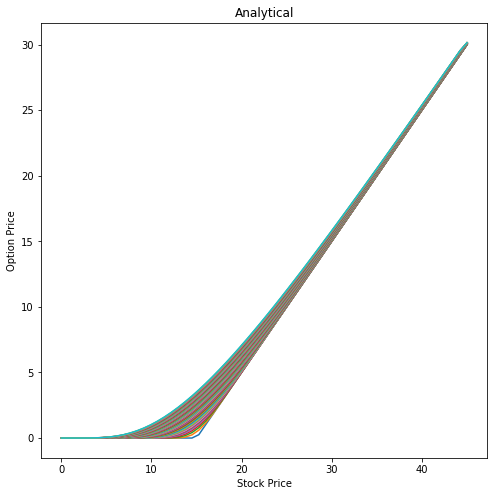

In [18]:
fig = plt.figure(figsize=[8,8]) 
for i in range(Ns):
  plt.plot(s_space,V_exact[i]) 
plt.title('Analytical')
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.savefig('1.png')   # save the figure to file
files.download('1.png')

## PLOTTING ANN PREDICTED SOLUTION

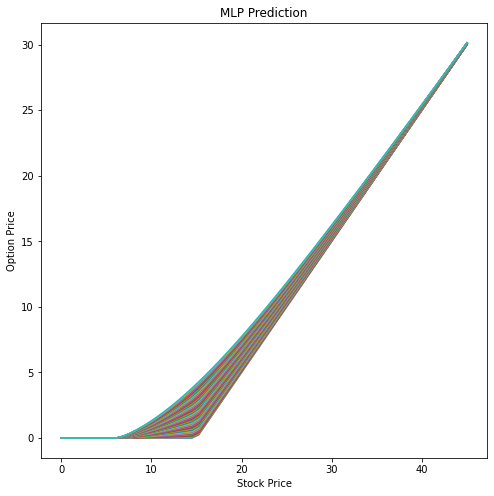

In [23]:
fig = plt.figure(figsize=[8,8]) 
for i in range(Ns):
  plt.plot(s_space,V(s_space, tau_space)[i]) 
plt.title('MLP Prediction')
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.savefig('2.png')   # save the figure to file
files.download('2.png')

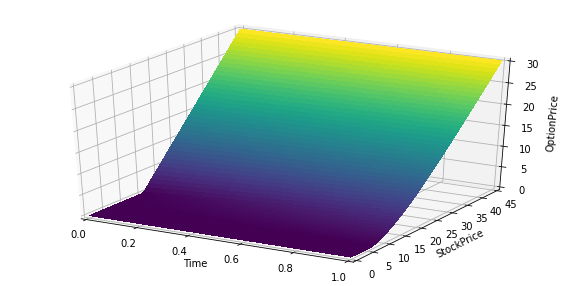

In [24]:
fig = plt.figure(figsize=[10,5])
ax = fig.gca(projection='3d')
s, t = np.meshgrid(s_space, tau_space)
surf = ax.plot_surface(t, s, V(s_space, tau_space), rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)

ax.set_xlim(0, T)
ax.set_ylim(0, smax)
ax.set_zlim(0, 30)

ax.set_xlabel('Time')
ax.set_ylabel('StockPrice')
ax.set_zlabel('OptionPrice')
plt.savefig('ANN.png')   # save the figure to file
files.download('ANN.png')

## TESTING THE MODEL
"Testing is not entirely essential since we are pricing in one domain. If we test, we must test using data points lie in our intial grid (domain)"\
For example:

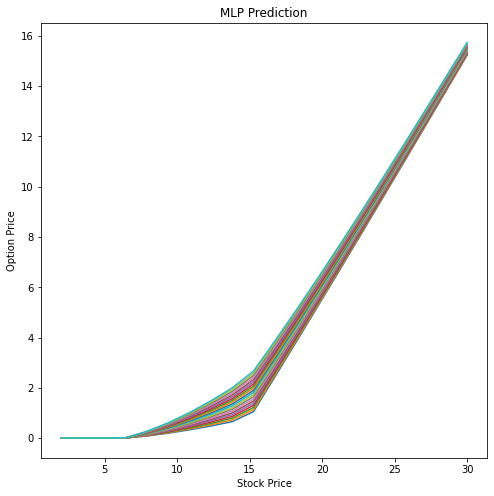

In [30]:
fig = plt.figure(figsize=[8,8]) 
V_test = V(s_test,tau_test)
for i in range(len(s_test)):
  plt.plot(s_test,V_test[i]) 
plt.title('MLP Prediction')
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.savefig('2.png')   # save the figure to file
files.download('2.png')

In [0]:
V_exactTest = analytical(s_test, tau_test)

In [0]:
fig = plt.figure(figsize=[8,8]) 
for i in range(len(s_test)):
  plt.plot(s_test,V_exactT[i]) 
plt.title('MLP Prediction')
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.savefig('2.png')   # save the figure to file
files.download('2.png')

In [0]:
fig = plt.figure(figsize=[10,5])
ax = fig.gca(projection='3d')
s, t = np.meshgrid(s_space, tau_space)
surf = ax.plot_surface(t, s, np.abs(V_exact), rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)

ax.set_xlim(0, T)
ax.set_ylim(0, smax)
ax.set_zlim(0, 30)

ax.set_xlabel('Time')
ax.set_ylabel('Stock Price')
ax.set_zlabel('Option Price')
plt.savefig('ANN.png')   # save the figure to file
files.download('ANN.png')

## MONTE CARLO SIMULATION

In [0]:
#%%timeit
# Value of Call using vectorised difference equation using Monte Carlo
import numpy as np
N= len(s_space)
t = tau_space
dt = T/(N-1)            # Time step
I = 1000
np.random.seed(1337)
V_MC = np.zeros((N,N))
s = np.zeros((N,I))   # Each column represents a single path  (I of these) and each row represents a t_i (N+1 of these)

for i in range(1, N):
  s[0,:]= s_space[i]              # value of each path at time t_0
  payoff=np.zeros(I)               

  for j in range(1,N):
    z = np.random.standard_normal(I)                   # draws from a standard normal distribution
    s[j,:]=s[j-1,:] * (1 + r * dt + sigma * np.sqrt(dt) * z)       # vector difference equation

    payoff = np.maximum(s[j,:] - k, 0)
    V_MC[0][i] = np.exp(-r * t[0]) * np.sum(payoff) / I
    V_MC[j][i] = np.exp(-r * t[i]) * np.sum(payoff) / I
#print(V_MC)

## ROOT MEAN SQUARE ERROR

In [34]:
rmse1 = np.sqrt((np.square(V_exact - V_MC)).mean(axis=None))
print(rmse1)

0.39158899379028506


## PLOTTING MONTE CARLO SOLUTION

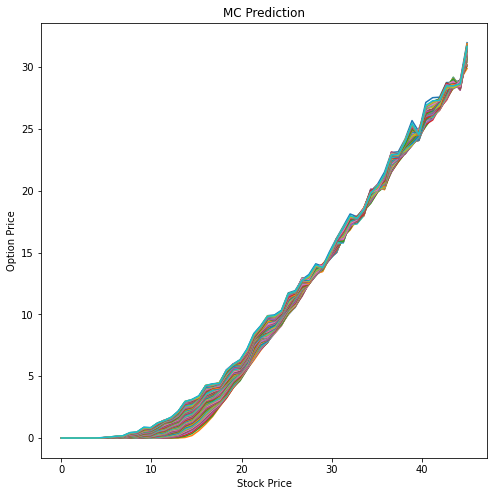

In [36]:
fig = plt.figure(figsize=[8,8]) 
for i in range(N):
  plt.plot(s_space,V_MC[i]) 
plt.title('MC Prediction')
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.savefig('3.png')   # save the figure to file
files.download('3.png')

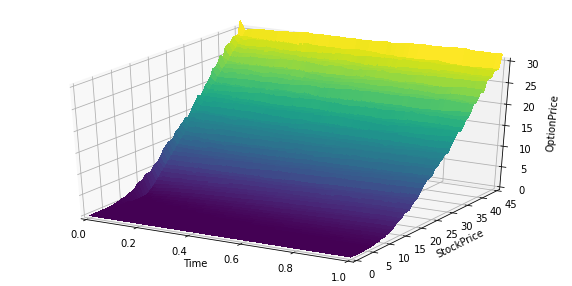

In [37]:
fig = plt.figure(figsize=[10,5])
ax = fig.gca(projection='3d')
s, t = np.meshgrid(s_space, tau_space)
surf = ax.plot_surface(t, s, np.abs(V_MC), rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)

ax.set_xlim(0, T)
ax.set_ylim(0, smax)
ax.set_zlim(0, 30)

ax.set_xlabel('Time')
ax.set_ylabel('StockPrice')
ax.set_zlabel('OptionPrice')
plt.savefig('ANN.png')   # save the figure to file
files.download('ANN.png')